In [130]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = (10, 6)
import warnings
warnings.filterwarnings('ignore')
import numpy as np
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV
from sklearn.model_selection import cross_val_score, StratifiedKFold
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error
from sklearn.neighbors import KNeighborsClassifier
from sklearn.pipeline import Pipeline

In [7]:
df = pd.read_csv('wine_prepared.csv')
df.head()

,v_acidity,chlorides,t_s_dioxide,density,alcohol,red,quality
0,0.70,0.076,34.0,0.9978,9.4,1,5
1,0.88,0.098,67.0,0.9968,9.8,1,5
2,0.76,0.092,54.0,0.9970,9.8,1,5
3,0.28,0.075,60.0,0.9980,9.8,1,6
4,0.66,0.075,40.0,0.9978,9.4,1,5


In [152]:
# Creating features and target data frame
X = df.iloc[:,:-1]
y = df.iloc[:,-1]

# Spliting into train and test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Normilizing
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

##### One decision tree regressor

In [153]:
dtree = DecisionTreeRegressor(max_depth = 4, random_state=17)
dtree.fit(X_train_scaled, y_train)
d_predict = dtree.predict(X_test_scaled)

print(f'MSE = {mean_squared_error(y_test,d_predict).round(2)}\nMean cross validation score = {abs(cross_val_score(dtree,X_train_scaled,y_train,scoring="neg_mean_squared_error")).mean().round(2)}')

MSE = 0.57
Mean cross validation score = 0.58


##### Random Forest

In [154]:
forest = RandomForestRegressor(random_state=17)

# Trying differnt depth of tries
forest_params = {'max_depth': list(range(9, 30))}

locally_best_forest = GridSearchCV(forest,forest_params,return_train_score=True, cv=3, n_jobs=-1)
locally_best_forest.fit(X_train_scaled, y_train)

GridSearchCV(cv=3, estimator=RandomForestRegressor(random_state=17), n_jobs=-1,
             param_grid={'max_depth': [9, 10, 11, 12, 13, 14, 15, 16, 17, 18,
                                       19, 20, 21, 22, 23, 24, 25, 26, 27, 28,
                                       29]},
             return_train_score=True)

In [155]:
locally_best_forest.best_params_, locally_best_forest.best_score_

({'max_depth': 9}, 0.2852132884370375)

In [156]:
print(f'MSE = {mean_squared_error(y_test,locally_best_forest.predict(X_test_scaled)).round(2)}\nMean cross validation score = {abs(cross_val_score(locally_best_forest,X_train_scaled,y_train,scoring="neg_mean_squared_error")).mean().round(2)}')

MSE = 0.52
Mean cross validation score = 0.55


Feature ranking:
1. alcohol 0.442284 
2. v_acidity 0.196706 
3. t_s_dioxide	 0.142116 
4. density	 0.113086 
5. chlorides 0.101465 
6. red 0.004343 


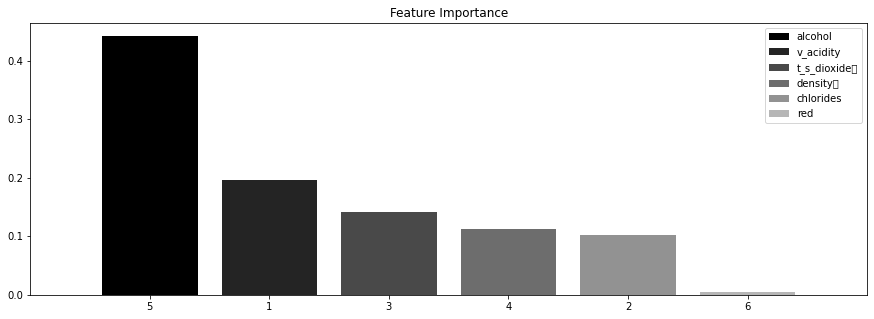

In [176]:
# Find features affect the result
forest = RandomForestRegressor(max_depth=9,random_state=17)
forest.fit(X_train_scaled, y_train)
importances = forest.feature_importances_
indices = np.argsort(importances)[::-1]

# Plot the feature importancies of the forest
features = {
    "f1": u"v_acidity",
    "f2": u"chlorides",
    "f3": u"t_s_dioxide	",
    "f4": u"density	",
    "f5": u"alcohol",
    "f6": u"red"
}
num_to_plot = 6
feature_indices = [ind + 1 for ind in indices[:num_to_plot]]

# Print the feature ranking
print("Feature ranking:")

for f in range(num_to_plot):
    print(
        "%d. %s %f "
        % (f + 1, features["f" + str(feature_indices[f])], importances[indices[f]])
    )
plt.figure(figsize=(15, 5))
plt.title(u"Feature Importance")
bars = plt.bar(
    range(num_to_plot),
    importances[indices[:num_to_plot]],
    color=([str(i / float(num_to_plot + 1)) for i in range(num_to_plot)]),
    align="center",
)
ticks = plt.xticks(range(num_to_plot), feature_indices)
plt.xlim([-1, num_to_plot])
plt.legend(bars, [u"".join(features["f" + str(i)]) for i in feature_indices]);

##### Logistic Regression

In [88]:
C = 1e-2
logit = LogisticRegression(C=C, random_state=17)
logit.fit(X_train_scaled, y_train)

LogisticRegression(C=0.01, random_state=17)

In [89]:
round(logit.score(X_train_scaled, y_train), 3), round(logit.score(X_test_scaled, y_test), 3)

(0.538, 0.528)

In [91]:
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=17)

# Trying differnt regularization coefficients 
c_values = np.logspace(-2, 3, 500)

logit_searcher = LogisticRegressionCV(Cs=c_values, cv=skf, n_jobs=-1)
logit_searcher.fit(X_train_scaled, y_train);

In [92]:
logit_searcher.C_

array([0.05514206, 0.05514206, 0.05514206, 0.05514206, 0.05514206,
       0.05514206, 0.05514206])

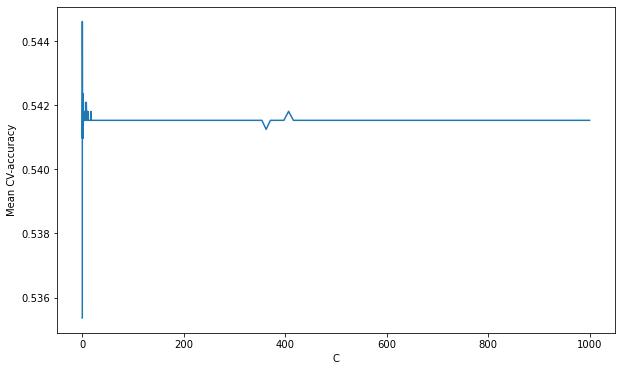

In [108]:
plt.plot(c_values, np.mean(logit_searcher.scores_[3], axis=0))
plt.xlabel("C")
plt.ylabel("Mean CV-accuracy");

In [174]:
C = 0.05514206
logit = LogisticRegression(C=C, random_state=17)
logit.fit(X_train_scaled, y_train)

print("MSE = %.2f" % mean_squared_error(y_test, logit.predict(X_test_scaled)))
round(logit.score(X_train_scaled, y_train), 3), round(logit.score(X_test_scaled, y_test), 3)

MSE = 0.65


(0.547, 0.527)

##### KNN

In [127]:
knn_pipe = Pipeline(
    [("scaler", StandardScaler()), ("knn", KNeighborsClassifier(n_jobs=-1))]
)

# Trying differnt number of neighbors
knn_params = {"knn__n_neighbors": range(1, 10)}

knn_grid = GridSearchCV(knn_pipe, knn_params, cv=5, n_jobs=-1, verbose=True)

knn_grid.fit(X_train_scaled, y_train)

knn_grid.best_params_, knn_grid.best_score_

Fitting 5 folds for each of 9 candidates, totalling 45 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  45 out of  45 | elapsed:    0.9s finished


({'knn__n_neighbors': 9}, 0.5134634476889863)

In [171]:
knn = KNeighborsClassifier(n_neighbors=9)
knn.fit(X_train_scaled, y_train)
knn_pred = knn.predict(X_test_scaled)

print("MSE = {:.2f}\nAccuracy score = {:.2f}".format(mean_squared_error(y_test, knn_pred),accuracy_score(y_test, knn_pred)))

MSE = 0.67
Accuracy score = 0.54
